# Módulo 31: Introducctión a Series de Tiempo - Parte 2
- Serie de Movimiento Browniano Geométrico (GBM)
    - Es un proceso de simulación estocástico donde el logaritmo de la variable sigue una trayectoria de Movimiento Browniano. Muy utilizado para modelar precios de acciones. La ecuación es:
    - No tiene memoria, únicamente tiene que ver con la media del periodo anterior y la volatilidad
    - Aplicación para precios de acciones o cualquier cosa que tenga movimientos aleatorios
- Serie de Reversión de la media (Mean Reversion)
    - Verios fenómenos como tasas de interés y la volatilidad de los retornos eventualmente vuelven a sus promedio de largo plazo
- Serie autoregresiva (AR)
    - Usa observaciones de periodos anteriores como entradas a una ecuación de regresión que sirve para predecir el valor del siguiente periodo
    - El término autoregresivo indica que es una regresión de la variable de respuesta consigo misma
    - También toma una variable de error (ruido blanco)
    - El modelo se define como AR(p), donde se tiene un modelo de orden p - es decir el número de variables en el tiempo que se van a utilizar. Cuando p >= 3, las restricciones son mucho más complejas
    - Casos especiales:
        - Si d1 = 0, yt = ruido blanco
        - Si d1 = 1, c = 0, yt es un random walk (GBM)
        - Si d1 = 1, c <> 0, yt es un random walk con drift
        - Si d1 < 0, yt oscila alrededor de una media
- Serie de Promedios Móviles (MA)
    - Moving Averages. Común para predecir modelos de series de tiempo univariables
    - Especifica que la salida yt no depende de sus mismos valores pasados (lags), sino de los errores pasados, usando un modelo de regresión
    - El modelo se define como MA(q) donde se tiene un modelo de orden q - es decir el número de variables en el tiempo que se van a utilizar
---
## Ejemplo 1: Mercado de valores



In [1]:
# Importar librerias
import warnings
# warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sn

In [2]:
# Libbrerías para uso estadístico

import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

In [3]:
# Se importa el archivo con datos
import os
os.chdir('D:/Documentos/Documentos/DataAnalysis/ebac/Python/Modulo30/')

df_apple = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
df_apple

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.269044,807234400
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.275722,619603600
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.257813,449422400
2006-01-06,2.687500,2.739286,2.662500,2.725000,2.316095,704457600
2006-01-09,2.740357,2.757143,2.705000,2.716071,2.308504,675040800
...,...,...,...,...,...,...
2017-12-22,43.669998,43.855000,43.625000,43.752499,41.483433,65397600
2017-12-26,42.700001,42.867500,42.419998,42.642502,40.431004,132742000
2017-12-27,42.525002,42.695000,42.427502,42.650002,40.438103,85992800


In [4]:
df_google = pd.read_csv('GOOG.csv', parse_dates=['Date'], index_col='Date')
df_google

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,10.523555,10.851077,10.416457,10.840119,10.840119,526815259
2006-01-04,11.056059,11.182087,10.952697,11.089434,11.089434,613747887
2006-01-05,11.108363,11.246595,10.996283,11.238874,11.238874,433952486
2006-01-06,11.379098,11.718576,11.288687,11.598028,11.598028,712938289
2006-01-09,11.616708,11.790805,11.480468,11.628912,11.628912,513593887
...,...,...,...,...,...,...
2017-12-22,53.055500,53.209999,52.972000,53.006001,53.006001,15102000
2017-12-26,52.903500,53.006001,52.509998,52.837002,52.837002,15212000
2017-12-27,52.869499,52.918499,52.402500,52.468498,52.468498,25438000


## Conceptos preeliminares
### Autocorrelación
- La función de autocorrelación (ACF) mide qué tan correlacionadas una serie está con ella misma
- Las unidades de la ACF son los diferentes periodos de tiempo (lags)
- Se la puede interpretar como una regresión de la series con uss lags anteriores
- Los términos se pueden interpretar como una regresión simple, es decir, la contribución de un cambio en cada lag, mientras se mantienen a los demás constantes

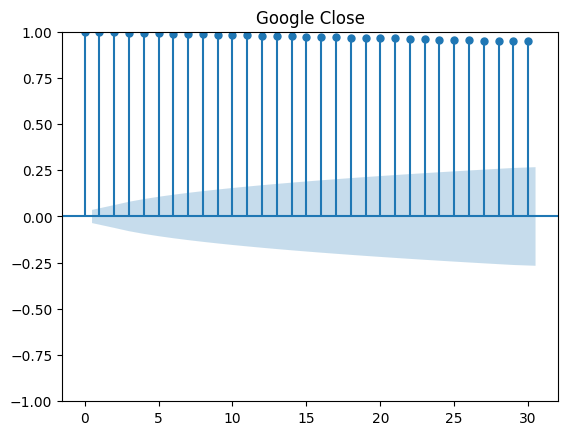

In [5]:
# Autocorrelación of Google Close
# Usar statsmodels
# Los lags van en el eje x y las correlaciones en el eje y
plot_acf(df_google['Close'], lags=30, title='Google Close')
plt.show()

### Insights:
- La mayoría de lags están cerca de 1 lo que quiere decir que tienen alta importancia
- Se puede ver además una tendencia a la baja, lo que nos indica que para la predicción, cada lag disminuye su fuerza (se incrementta el área sombreada)

## Función Parcial de Autocorrelación

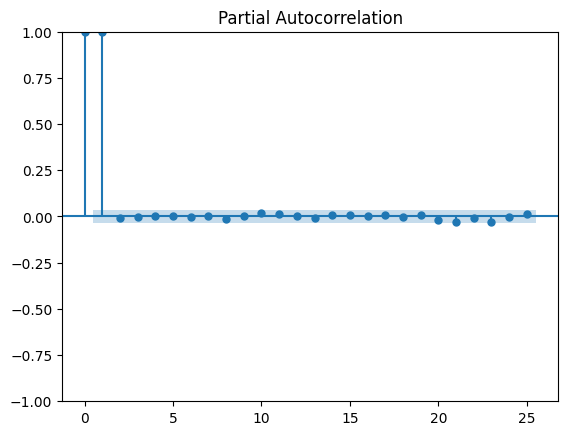

In [6]:
# Esta función genera la correlación parcial entre los valores de una serie de titempo y sus lags atneriores
# La correlación parcial es un cálculo de correlación que toma en cuenta las observcaciones de la serie de tiempo separadas por sus lags, luedo de ajustar por la presencia de otros términos con lags mas pequeños (lo que la diferencia de ACF)
# También nos indica cuál es la importancia de los lags en la predicción

plot_pacf(df_google['Close'], lags=25)
plt.show()

### Insights:
- Se ve como el t0 y t1 tienen una alta correlación parcial (PACF, mientras que los demás no tanto)
- Mi memoria es básicamente de un día

### White Noise (Ruido Blanco)
- Es una generación de información aleatoria con intensidades imilares en cada frecuencia
- Es una secuencia de variables aleatorias, no relacionadas, con una media constante (estacionarias) y varianza limitada
- Además tiene cero correlación en sus lags (ACF)

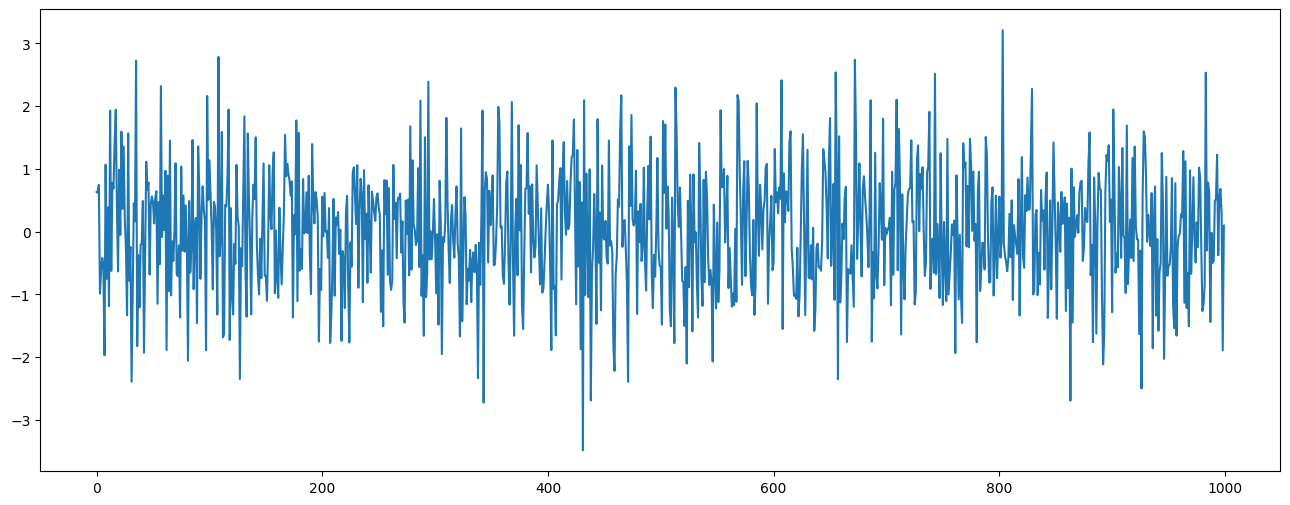

In [7]:
from pylab import rcParams
# Plotting white noise
rcParams['figure.figsize'] = 16,6
white_noise = np.random.normal(loc=0, scale=1, size=1000)

# loc is mean, scale is variance
plt.plot(white_noise)


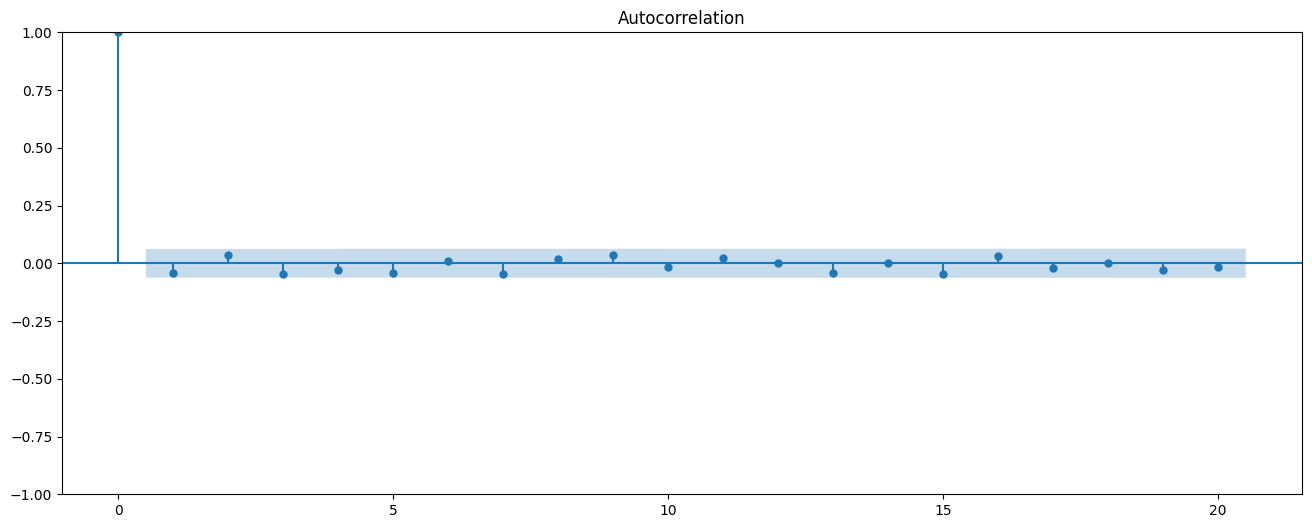

In [8]:
# Visualización de autocorrelación de ruido blanco
# Según las definiciones anteriores, debería ser cero, que es lo que se puede apreciar en el gráfico
plot_acf(white_noise, lags=20)
plt.show()


---
## Serie Geometric Brownian Motion
- Serie aleatoria utilizada para predecir precios de stocks y movimientos tipo random walk
- https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html


In [9]:
from scipy.stats import norm
import pandas as pd

# Parámetros del proceso
delta = 0.25
dt = 0.1

#Punto inicio
x = 0.0
xini = 0

# Número de iteraciones
n = 10

# Genera los distintos puntos de la serie
for k in range(n):
    x = x + norm.rvs(scale=delta**2*dt)
    print(x)

0.0029831526424336395
-6.005213874308614e-05
-0.00996862772650921
-0.014404991201769187
-0.02256455639531802
-0.02006504071334398
-0.032981796379233486
-0.03930361635674468
-0.03618663695279683
-0.03052696423123545


In [10]:
# Número de trayectorias
ntra = 10

# Número de iteraciones 
n = 20

# Se pueden guardar los caminos diferenes en un dataframe
res = []
dfres = pd.DataFrame().assign(traj=0, nsample=0, sample=0)
dfres

,traj,nsample,sample


In [11]:
# Genera las trayectorias en un dataframe (dfres)
for i in range(ntra+1):
    for k in range(1,n+1):
        x = x + norm.rvs(scale=delta**2*dt)
        res.append(x)
        df2 = {'traj': i, 'nsample':k, 'sample':x}
        dfres = pd.concat(objs=[dfres, pd.DataFrame(df2, index=[0])], axis=0, ignore_index=True)
        # dfres = dfres.append(df2, ignore_index=True)


# Genera los puntos iniciales en 0
for i in range(ntra+1):
    df2 = {'traj': i, 'nsample':0, 'sample': xini}
    dfres = pd.concat(objs=[dfres, pd.DataFrame(df2, index=[0])], ignore_index=True, axis=0)
    # dfres = dfres.append(df2, ignore_index=True)
dfres

,traj,nsample,sample
0,0,1,-0.032049
1,0,2,-0.039851
2,0,3,-0.034478
3,0,4,-0.034840
4,0,5,-0.031729
...,...,...,...
226,6,0,0.000000
227,7,0,0.000000
228,8,0,0.000000
229,9,0,0.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_4904\1469885987.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




<AxesSubplot: xlabel='nsample', ylabel='sample'>

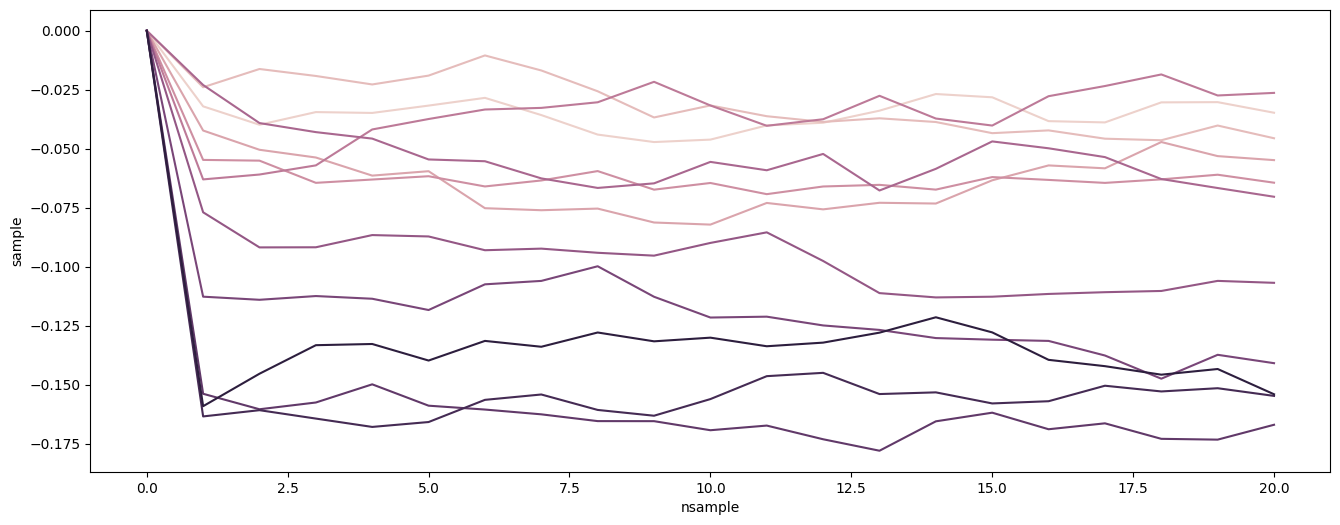

In [12]:
import seaborn as sns
sns.lineplot(data=dfres, x='nsample', y='sample', legend=None, ci=None, hue='traj')

In [13]:
# Ejemplo Ventas

# Se puden obtener las trayectorias con una pivot table (y obtener las medidas como media, etc. para cada trayectoria)
pd.pivot_table(dfres, index=['traj'], columns=['nsample'])

sample                                                              \
nsample     0         1         2         3         4         5         6    
traj                                                                         
0          0.0 -0.032049 -0.039851 -0.034478 -0.034840 -0.031729 -0.028453   
1          0.0 -0.023942 -0.016221 -0.019174 -0.022768 -0.019020 -0.010473   
2          0.0 -0.042297 -0.050451 -0.053726 -0.061403 -0.059529 -0.075209   
3          0.0 -0.054744 -0.055059 -0.064461 -0.063059 -0.061660 -0.065990   
4          0.0 -0.063006 -0.060939 -0.057064 -0.041841 -0.037417 -0.033387   
5          0.0 -0.023003 -0.039132 -0.042969 -0.045718 -0.054555 -0.055310   
6          0.0 -0.076945 -0.091821 -0.091770 -0.086599 -0.087183 -0.093018   
7          0.0 -0.112706 -0.114021 -0.112438 -0.113581 -0.118357 -0.107470   
8          0.0 -0.153851 -0.160413 -0.157549 -0.149848 -0.158897 -0.160535   
9          0.0 -0.163447 -0.160805 -0.164362 -0.167898 -0.165827 -0.156426   
10         0.0 -0.159110 -0.145351 -0.133263 -0.132756 -0.139768 -0.131446   

                                       ...                                \
nsample        7         8         9   ...        11        12        13   
traj                                   ...                                 
0       -0.035744 -0.044012 -0.047178  ... -0.040135 -0.038990 -0.033884   
1       -0.016846 -0.025657 -0.036755  ... -0.036228 -0.038640 -0.037111   
2       -0.076067 -0.075378 -0.081272  ... -0.072985 -0.075699 -0.072913   
3       -0.063459 -0.059478 -0.067349  ... -0.069259 -0.066008 -0.065315   
4       -0.032700 -0.030321 -0.021654  ... -0.040288 -0.037510 -0.027578   
5       -0.062579 -0.066620 -0.064679  ... -0.059134 -0.052214 -0.067702   
6       -0.092343 -0.094101 -0.095318  ... -0.085443 -0.097574 -0.111194   
7       -0.106022 -0.099812 -0.112741  ... -0.121176 -0.124893 -0.126788   
8       -0.162564 -0.165434 -0.165458  ... -0.167328 -0.173125 -0.177983   
9       -0.154154 -0.160698 -0.163152  ... -0.146386 -0.144980 -0.153967   
10      -0.133928 -0.127883 -0.131623  ... -0.133712 -0.132176 -0.127950   

                                                                               
nsample        14        15        16        17        18        19        20  
traj                                                                           
0       -0.026825 -0.028208 -0.038315 -0.038855 -0.030362 -0.030268 -0.034759  
1       -0.038687 -0.043412 -0.042237 -0.045753 -0.046414 -0.040177 -0.045567  
2       -0.073232 -0.063388 -0.057080 -0.058307 -0.047168 -0.053138 -0.054833  
3       -0.067334 -0.062025 -0.063221 -0.064484 -0.062988 -0.061021 -0.064406  
4       -0.037215 -0.040185 -0.027745 -0.023437 -0.018528 -0.027441 -0.026344  
5       -0.058525 -0.046911 -0.049820 -0.053554 -0.062854 -0.066656 -0.070360  
6       -0.113017 -0.112717 -0.111544 -0.110802 -0.110282 -0.106013 -0.106834  
7       -0.130244 -0.130930 -0.131450 -0.137635 -0.147458 -0.137336 -0.140886  
8       -0.165525 -0.161865 -0.168883 -0.166376 -0.172945 -0.173285 -0.166984  
9       -0.153253 -0.157946 -0.157008 -0.150440 -0.152863 -0.151498 -0.154753  
10      -0.121434 -0.127839 -0.139472 -0.142151 -0.145759 -0.143356 -0.154061  

[11 rows x 21 columns]

## Serie Reversión a la Media
- Conocido como el modelo Vasicek
- Muy utilizado para predecir tasas de Bancos Centrales, niveles de actividad económicos

In [14]:
def mod_vasicek(r0, K, theta, sigma, T=1, N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    for i in range(N):
        dr = K*(theta-rates[-1])*dt + sigma*np.random.normal()
        rates.append(rates[-1]+dr)
    return range(N+1), rates

In [15]:
# Parámetros para la serie de tiempo
r0 = 0.1875             # Punto inicial
K = 0.2                 # Velocidad de reversión a la media
theta = 0.04            # Nivel de largo plazo de la variable
sigma = 0.012
T = 10
seed = np.random.randint(100,900)
N = 1000

# Llama a la función Vasicek
x, y = mod_vasicek(r0, K, theta, sigma, T, N, seed)

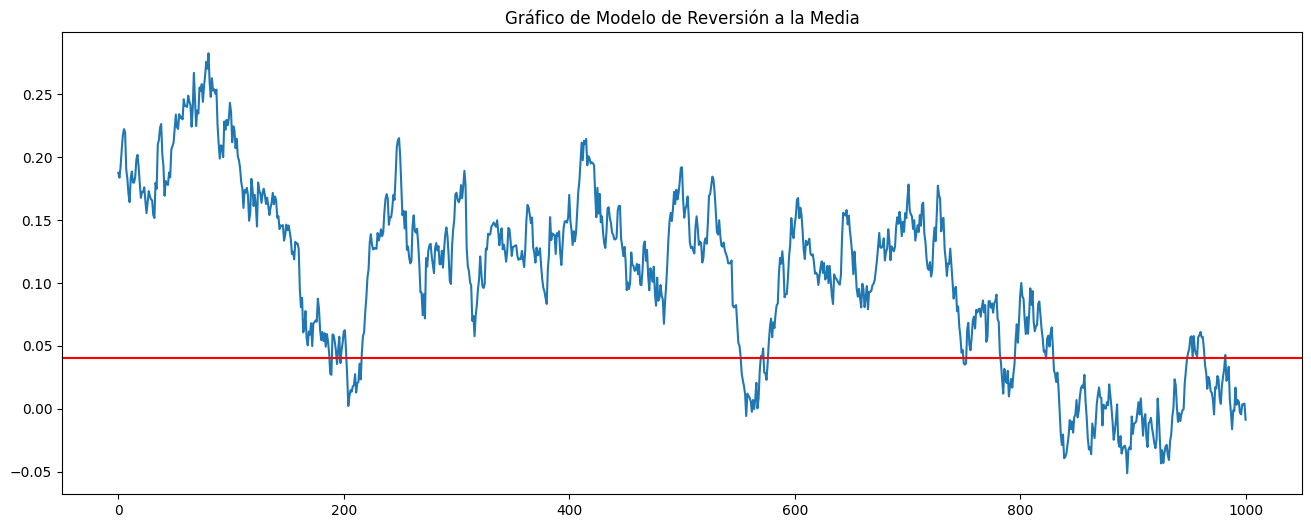

In [16]:
# Generación de gráfica del modelo de Reversión a la Media
plt.plot(x,y)
plt.title('Gráfico de Modelo de Reversión a la Media')
plt.axhline(theta, color='red')
plt.show()

## Serie de Tiempo Autorregresiva (AR)
- Representación de un tipo de proceso aleatorio con regresiones sobre las mismas variables
- Utilizado para describir un proceso de variación en tiempo de la naturaleza, economía, etc.
- Especifica que la variable de salida depende linealmente en sus valores previos además de un término estocástico (aleatorio)

In [17]:
# Configuración de la Serie Autorregresiva (AR)
# Se generarán 4 diferentes gráficas, con dos niveles de AR, AR(1) y AR(2)
# Se utilizará Statsmodels.tsa.arima_process.ArmaProcess y la función generate_sample()
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
# Como se ve, no es necesario generar la ecuación de la serie de tiempo

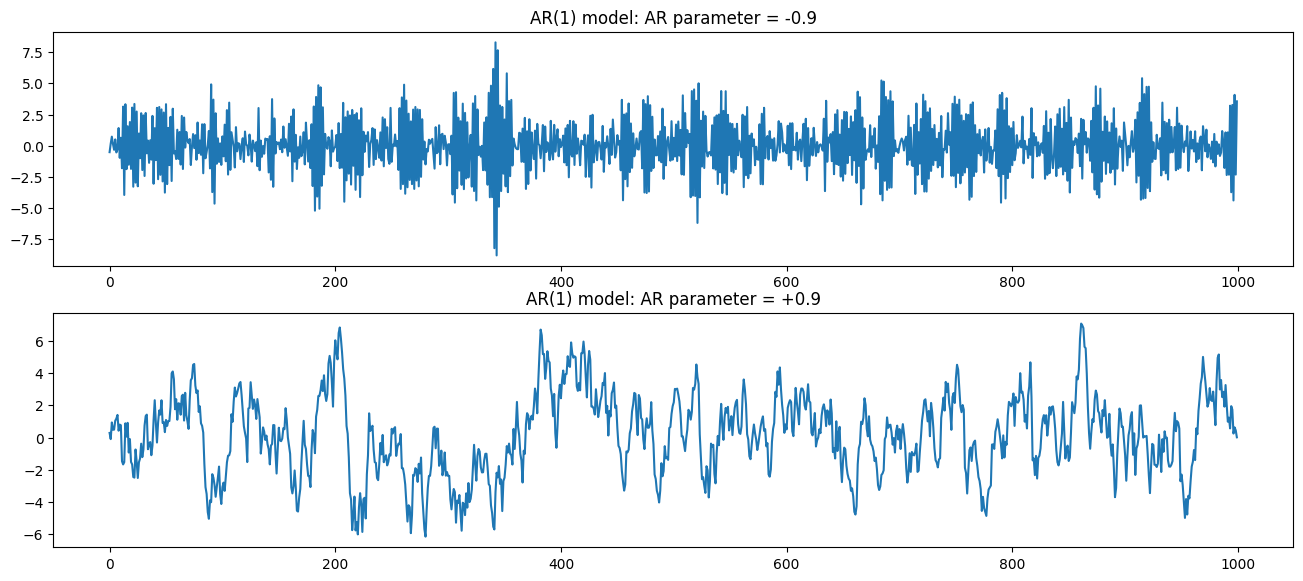

In [18]:
# Generación de la Serie de Tiempo AR
# AR(1) MA(1) model:AR parameter = 0.9
rcParams['figure.figsize'] = 16, 14

from statsmodels.tsa.arima_process import ArmaProcess

# Se especifican los parámetros de AR y MA (AR +0.9)
plt.subplot(4,1,1)
ar1 = np.array([1, 0.9])
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim1)

# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, -0.9])
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim2)


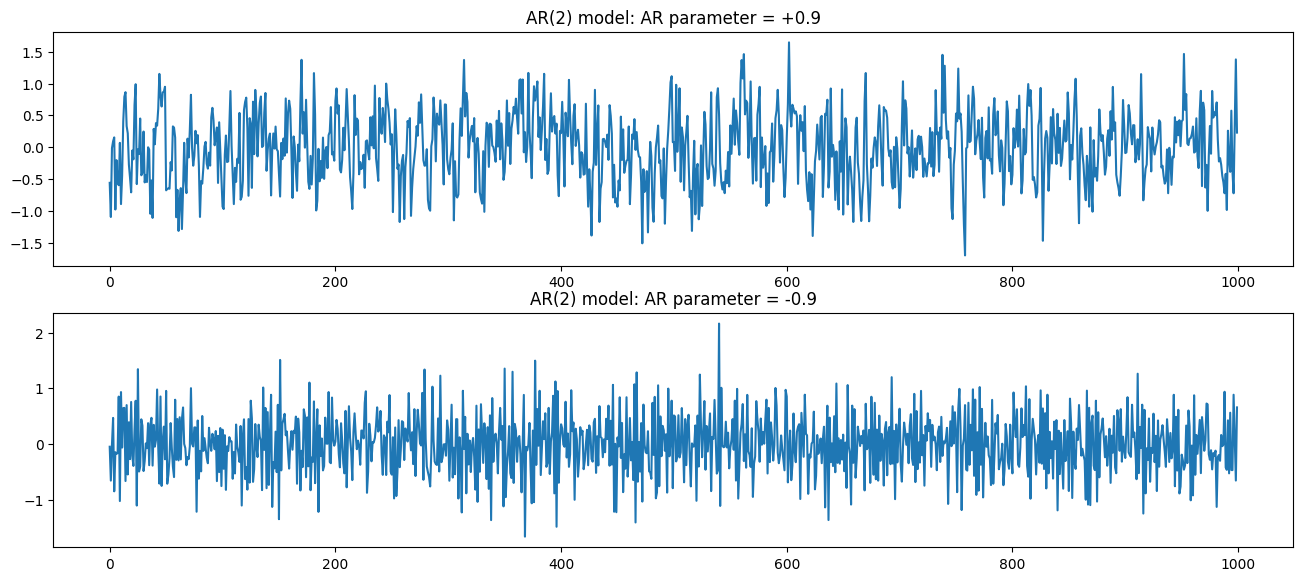

In [19]:
# Ahora se genera la misma serie pero con AR(2)

# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9])       # Se escoge -0.9 para que el parámetri sea 0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)

# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9])       # Se escoge +0.9 para que el parámetri sea -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)

In [24]:
# Forecasting con AR
# Se usa el model.fit para hacer la predicción automática
# Se muestra como va iterando el proceso del fit hasta que llega a un nivel de predicción adecuado
# Fit de la serie aleatoria sim1 generada antes

# https://www.statsmodels.org/0.8.0/generated/statsmodels.tsa.arima_model.ARMA.html
# New version (used here) https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(sim1, order=(1,0,0))
result = model.fit()


# Other resources
# https://medium.com/@ooemma83/clear-explanations-of-ar-ma-arma-and-arima-in-times-series-analysis-9a72ff569dee
# https://www.bbk.ac.uk/ms/brooms/teaching/TSF/SMTS-06.pdf


In [32]:
# Después del fit, podemos revisar cuáles fueron los parámetros
# a los que se llegó luego de la predicción e incluso graficar
# Cómo interpretar los resultados: https://medium.com/analytics-vidhya/interpreting-arma-model-results-in-statsmodels-for-absolute-beginners-a4d22253ad1c

print(f'μ={result.params[0]:.6} ,  θ={result.params[1]:.6}')
print(result.summary())


μ=0.00566133 ,  θ=-0.885775
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1436.399
Date:                Wed, 11 Oct 2023   AIC                           2878.799
Time:                        18:55:50   BIC                           2893.522
Sample:                             0   HQIC                          2884.395
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.017      0.332      0.740      -0.028       0.039
ar.L1         -0.8858      0.014    -62.158      0.000      -0.914      -0.858
sigma2         1.0339   

### Explicación
- ARMA(1,0) que es lo mismo que ARIMA (1,0,0) indica los parámetris usados en el modelo
- Log Likelihood no tiene medida, pero mientras más mejor, se compara entre métodos
- AIC (Akaike Info Criteria), BIC (Bayesian Info Criteria), HQIC (Hannan-Quinn Info Criteria)
- Buscar AIC con valores bajos, ya que este método toma en cuenta el prinicipio de parsimonia (menos parámetros = mejor). Además toma en cuenta el cálculo de la máxima verosimilitud (log likelhood)
- BIC es parecido a AIC pero también toma en cuenta el número de filas del modelo. Mientras más bajo mejor
- HQIC es menos utilizado

### Tabla de coeficientes
- Coefficient. Shows the model (ar or ma). Lag (L1, L2)
- Std Err. Estimado del error del valor predicho. Muestra cuán fuerte es el efecto del error residual en los parámetros estimados
- z = coef / std err
- P>z es el p-value del coeficiente. Si es mayor a 0.05 se debe tomar en cuenta (descartar?) ya que se puede estar usando un coeficiente no significativo
- Las últimas columnas representan el intervalo de confianza: coef +/- error margin

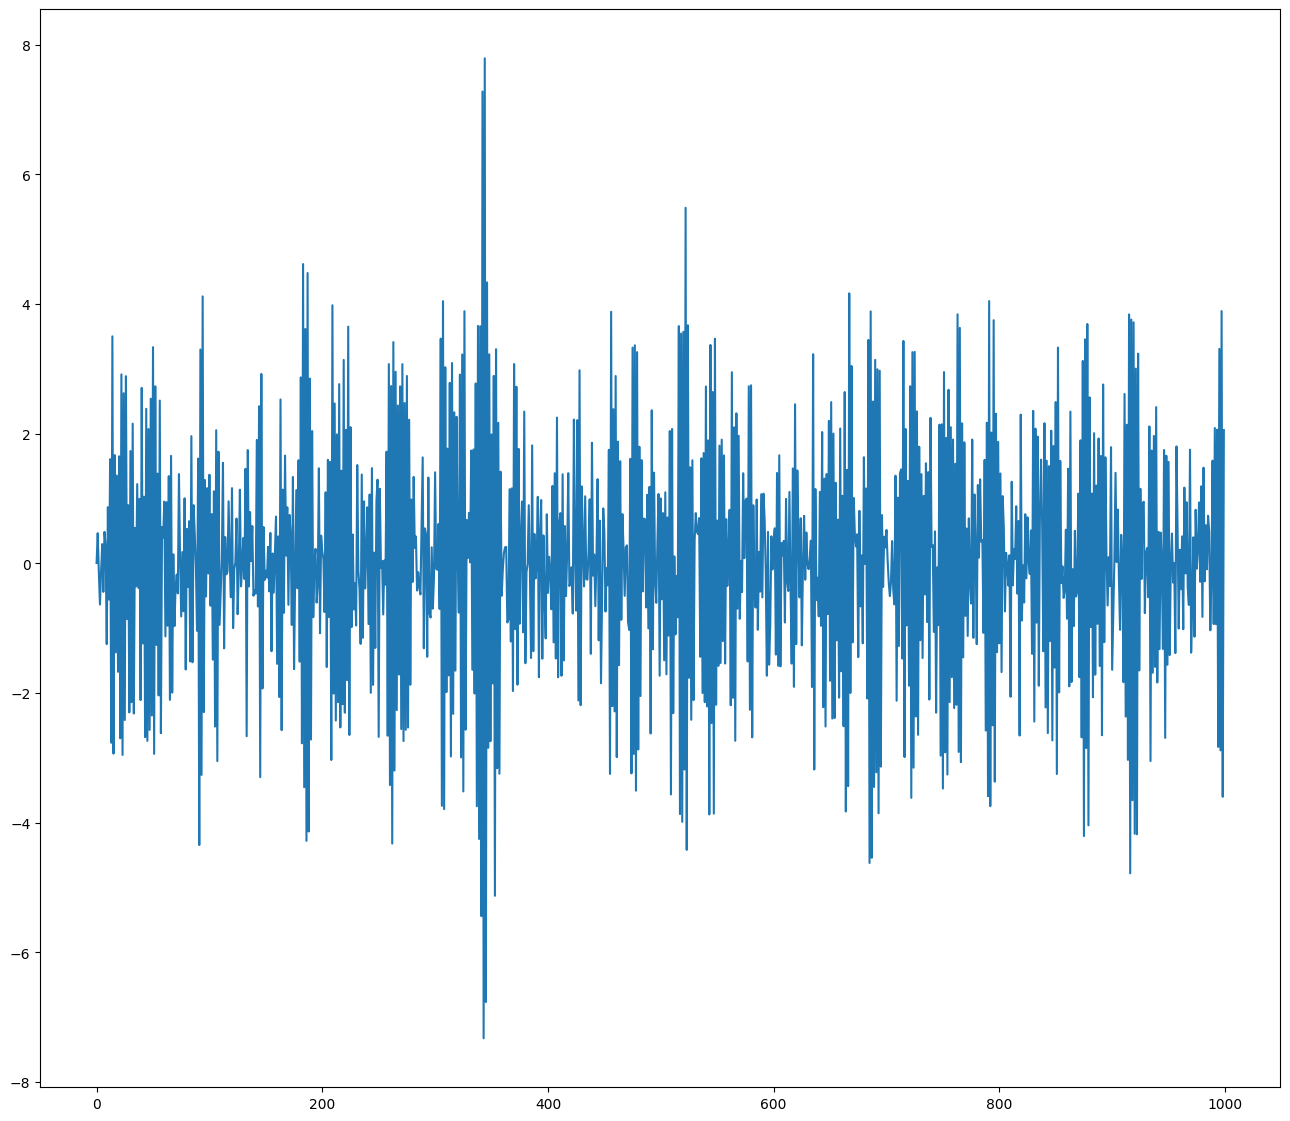

In [44]:
# Se muestra la predicción con un plot_predict
# https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.arima_model.ARMAResults.plot_prediction.html

plt.plot(result.predict())

In [46]:
# Se evalúa el modelo con Root Mean Squared Error
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900, end=999)))
print(f'RMSE = {rmse}')

RMSE = 1.0300555567716057


d:\Programas\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



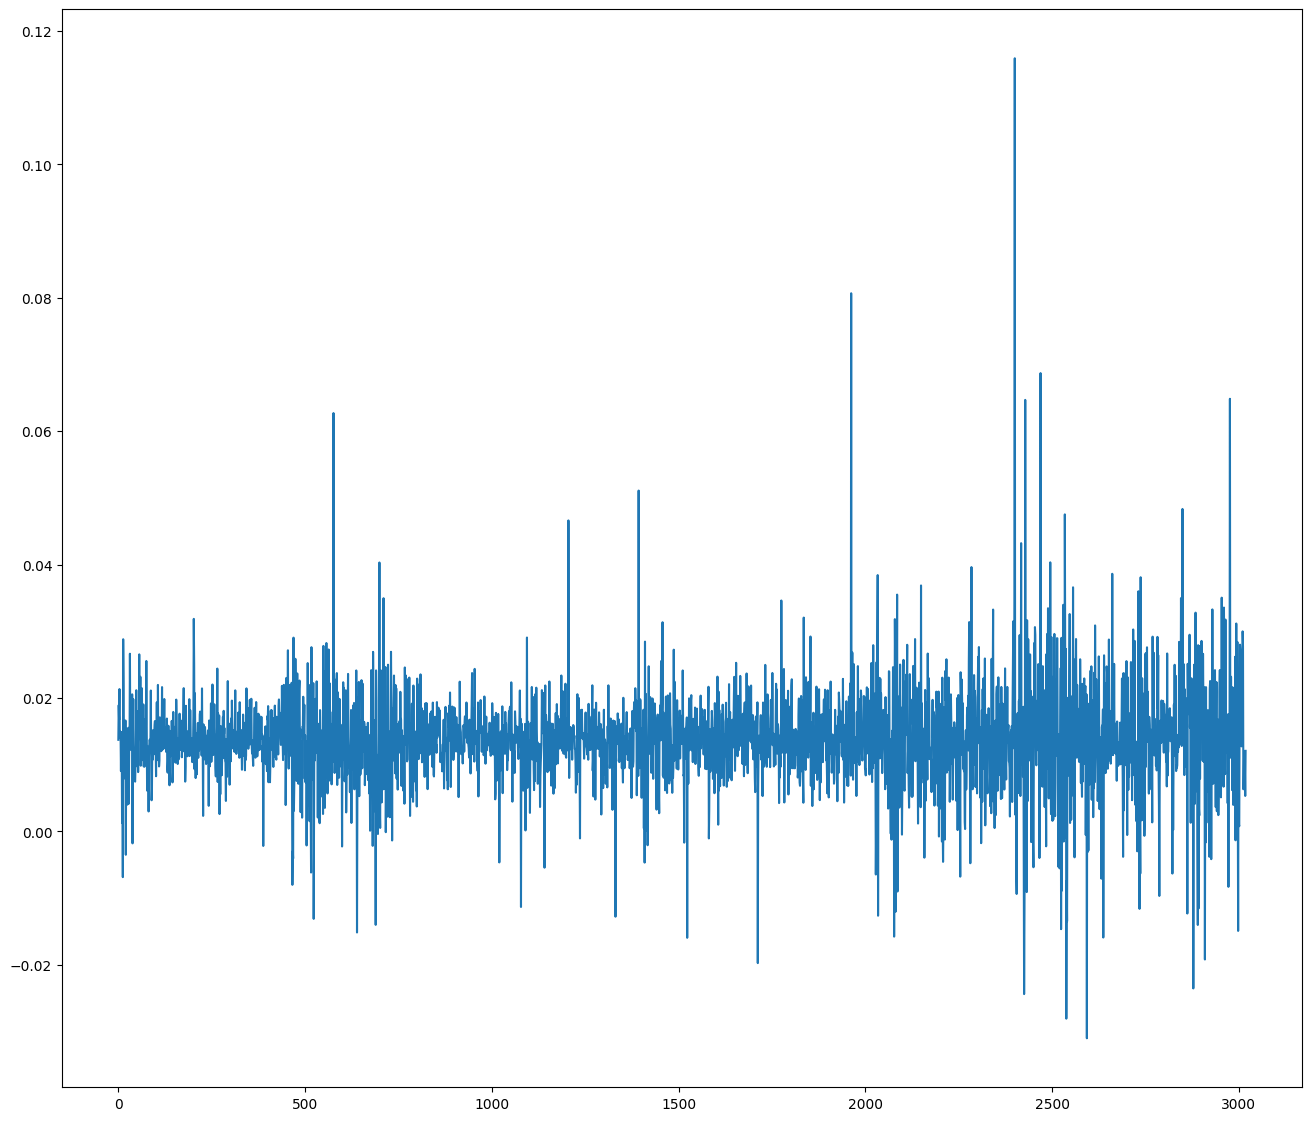

In [51]:
# Predicción de Precio de Google
google_price = ARIMA(df_google['Close'].diff().iloc[1:].values, order=(1,0,0))      # Lo que queremos predecir es la diferencia entre el close de un día y el del anterior
res = google_price.fit()
plt.plot(res.predict())

In [53]:
rmse = math.sqrt(mean_squared_error(df_google['High'].diff().iloc[900:1000].values, result.predict(start=900, end=999)))
print(f'RMSE = {rmse}')

RMSE = 1.8677334674110257


## Moving Averages Series
- Las series de tipo MA tienen una aproximación para modelar series de tiempo univariadas
- El modelo de promedios móviles especifica que la salida depende linearmente de la prediccón de los términos de error y además un término estocástico no calculable


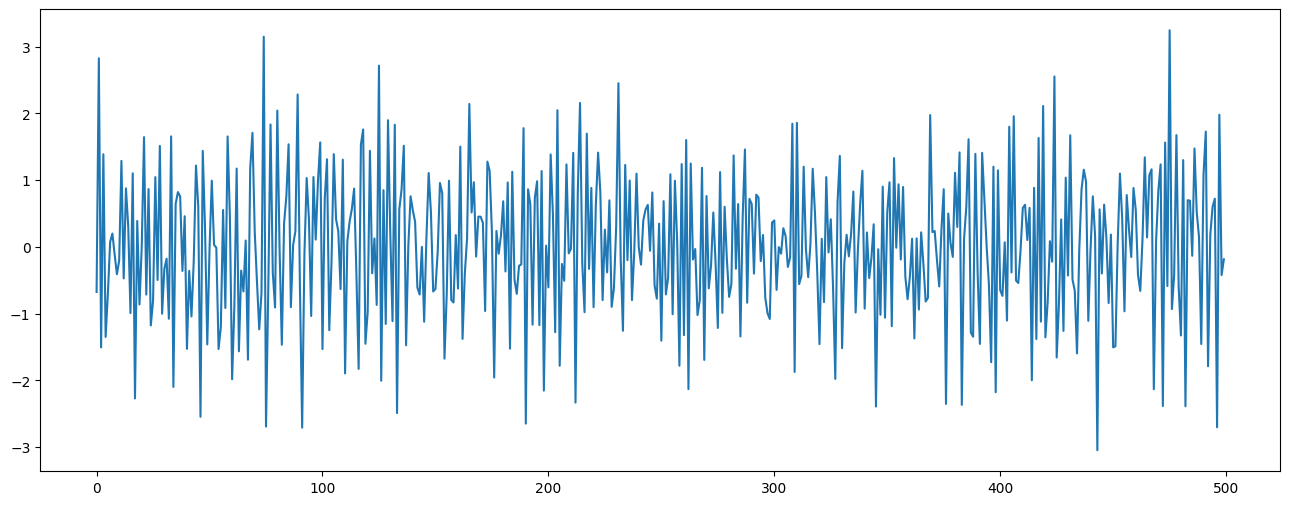

In [57]:
# Generación de una serie de tipo MA con 0.5
# También se usa el ArmaProcess y generate sample como en las series de AR
# Como en el modelo anterior, no es necesario generar la ecuación que se tiene como base
# Pero sí entender las implicaciónes de las mismas

# Generación de una serie aleatoria
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1,-0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=500)
plt.plot(sim1)

In [58]:
# Forcasting con MA
# Se utiliza el modelo ARMa y luego el model.fit()
model = ARIMA(sim1, order=(0,0,1))
result = model.fit()

In [60]:
# Se imprimen los resultados 
print(f'μ={result.params[0]:.6} ,  θ={result.params[1]:.6}')
print(result.summary())

μ=0.00698113 ,  θ=-0.471997
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -709.343
Date:                Wed, 11 Oct 2023   AIC                           1424.687
Time:                        19:22:23   BIC                           1437.331
Sample:                             0   HQIC                          1429.648
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.024      0.294      0.769      -0.040       0.053
ma.L1         -0.4720      0.043    -11.103      0.000      -0.555      -0.389
sigma2         0.9990   

In [62]:
# Predicciones para el precio de Google
# Lo que se va a predecir son las variaciones absolutas

# Se define la serie ARMA y luego se procede con el model fit
# Order tiene los parámetros p,(d) y q de AR y MA respectivamente
model = ARIMA(df_google['Close'].diff().iloc[1:].values, order=(0,0,3))
result = model.fit()

In [63]:
print(f'μ={result.params[0]:.6} ,  θ={result.params[1]:.6}')
print(result.summary())

μ=0.0137378 ,  θ=0.0209129
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3019
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -1038.349
Date:                Wed, 11 Oct 2023   AIC                           2086.698
Time:                        19:26:57   BIC                           2116.761
Sample:                             0   HQIC                          2097.508
                               - 3019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.006      2.141      0.032       0.001       0.026
ma.L1          0.0209      0.013      1.605      0.108      -0.005       0.046
ma.L2          0.0069    

In [65]:
rmse = math.sqrt(mean_squared_error(df_google['High'].diff().iloc[900:1000].values, result.predict(start=900, end=999)))
print(f'RMSE = {rmse}')

RMSE = 0.1333244447042133


In [67]:
# Qué pasaría si tratamos de predecir los precios?
# Error!
model = ARIMA(df_google['Close'].values, order=(0,0,3))
result = model.fit()

# Este error sucede porque la serie no converge en un precio, si lo predecimos a partir de la diferencia de precios con el día an terior (como antes) la serie va a oscilar alrededor del cero porque a veces sube y a veces baja, la serie es ahora un delta de los precios
# en lugar del precio final

d:\Programas\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



#### Insights 
- Se puede ver cómo la serie lo que hace es tomar las variaciones y encontrar ese nivel
- Las series de tiempo nos pueden servir para predecir muchos fenómenos
- Se debe hacer prueba y error para encontrar los niveles de AR y MA necesarios
- Saber leer los resultados
---
## Predicción de clima

In [ ]:
# Bonus Track
# Predicción de Clima
# df_sp = pd.read_csv('ClimaSP')